In [2]:
# import numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt

# import mini MD modules
from miniMD import models
from miniMD import samplers

Consider a binary classification problem, for a given set of paired data $(x_i,y_i)_{1 \leq i \leq N}$, where $y_i \in \mathbb{R}^d$ denotes the predictor variable and $y_i \in \{0, 1\}$ the response variable. Let $X_i$ and $Y_i$ as described above be i.i.d. random variables associated with the observations $(y_i,z_i)$, respectively. A common way to model the dependence between the predictor variable and the response variable in binary classification problems is to assume that the conditional probability of the event $Y_i = 1$ given $X_i$ is described by the values of the logistic function evaluated at a linear transformation of $X_i$, i.e.,

$$
\mathbb{P}(Y_i =1|X_i)=f( x_i \beta^T\,)
$$

hence 
$$\mathbb{P}(Y_i \beta^T X_i) = f(Y_i \beta^T X_i),$$
where
$$
f(s) = \frac{1}{1+e^{-s}}.
$$
is the logistic function and the weights w ∈ Rn define the linear transformation. In a Bayesian setup, the weights are considered to be random variables distributed according to a prior distribution, w ∼ π. By Bayes rule, the posterior distribution over w is then found to be,
$$
p(\beta | x,y) \propto \pi(\beta) p(y, | x, \beta) = \pi(\beta) \prod_{i=1}^N f( x_i \beta^T\, y_i ). 
$$
Using the posterior distribution we can predict the class label of a new data point as 
$$
\mathbb{P}[y_{pred} | x_{pred},x,y] = \int f(x_{pred}^T\beta) p(\beta | x,y) d \beta
$$
In practice the integral on the left hand side of the equation is intractable. This is were sampling comes into play. One generate a sample $(\beta^(k))_{1\leq k \leq N_{steps}}$ from the posterior distribution and approximate the integral term as 
$$
\int f(x_{pred}^T\beta) p(\beta | x,y) d \beta  \approx \frac{1}{N_{steps}}\sum_{k=1}^{N_{steps}} f(x_{pred}^T\beta^{(k)})
$$

In this exercise we will consider a simple logistic regression classfier using a synthetic dataset of $N$ paired observations $(x_i,y_i)_{1\leq i \leq N}$, with $x_i \in \mathbb{R}^2$ being the predictor variable and $y_i\in \{0,1\}$ being the class label as a training set. The code below creates such a synthetic dataset.

In [21]:
np.random.seed(seed=11) #Fix seed 

data_dim = 2 # Dimension of predictor variable
Ndata1 = 10  # Number of points with class label 0
Ndata2 = 10  # Number of points with class label 1

mu1 = np.array([-4,0]) # mean of predictor variables with class label 0
mu2 =  np.array([4,0]) # mean of predictor variables with class label 1
cov1 = np.eye(data_dim) # covariance of predictor variables with class label 0
cov2 = np.eye(data_dim) # covariance of predictor variables with class label 1


# Sample data points 
X1 = np.random.multivariate_normal(mu1,cov1,size=Ndata1)
Y1 = np.zeros(Ndata1)
X2 = np.random.multivariate_normal(mu2,cov2,size=Ndata2)
Y2 = np.ones(Ndata2)

X = np.concatenate((X1,X2))
Y = np.concatenate((Y1,Y2)) 


data = [X,Y] # data set in the format used in the logistic regression model below



You can plot the data set using the code the following code

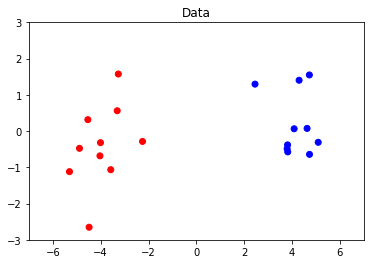

In [22]:
ndata = Y.shape[0]
color_dict= {0:'red', 1 :'blue'}
colors = [color_dict[Y[i]] for i in range(ndata)]
plt.scatter(X[:,0],X[:,1], c=colors)
plt.title('Data') 
plt.xlim([mu1[0]-3*np.sqrt(cov1[0,0]),+mu2[0]+3*np.sqrt(cov2[0,0])])
plt.ylim([mu1[1]-3*np.sqrt(cov1[1,1]),+mu2[1]+3*np.sqrt(cov2[1,1])])
plt.show()

A suitable logistic regression model specifying a posterior distribution $p(\beta | x,y)$ of a form as described above is implemented in the class "BayesianLogisticRegression". The implemented regression model assumes a Gaussian prior. The code below initializes the classifier model we will use in the following. 
 - Note: In the code $q$ should be interpreted as $\beta$, i.e., the output of our sampler corresponds to trajectory of samples distributed according to $p(\beta | x,y)$ 

In [17]:
q0 = np.zeros(data_dim)
p0 = np.random.normal(0., 1., data_dim)
model = models.BayesianLogisticRegression(prior_mean = np.zeros(data_dim),
                                               prior_cov = 100*np.eye(data_dim),
                                               data = [X,Y], 
                                               q=q0, 
                                               p=p0
                                         )

## Task 1
- Set up an Ensbemble Quasi Newton sampler to sample from the posterior of the Bayesion logistic regression model specified above. It is recommended to use 10 replicas and a stepsize of $\Delta t = .01$. Ensure that the number of time steps is sufficiently large that you get good exploration of your sampling space. (Hint: You may want to inspect the trace plot of $\beta_1$ and $\beta_2$ for this)

## Task 2 
After you have obtained a sample trajectory using the Quasi Ensemble Newton method, you can ue the below code to plot the prediction $\mathbb{P}[y_{pred} | x_{pred},x,y]$ for points on the grid $x_{pred} \in$ grid. Where grid = xx1 $\times$ xx2, with the vectors xx1 and xx2  as specified below. 
If computations take to much time you may want to adapt the values of Nx1, Nx2, Neval.

In [ ]:
Nx1 = 50
Nx2 = 50
xx1 = np.linspace(mu1[0]-3*np.sqrt(cov1[0,0]),+mu2[0]+3*np.sqrt(cov2[0,0]),Nx1)
xx2 = np.linspace(mu1[1]-3*np.sqrt(cov1[1,1]),+mu2[1]+3*np.sqrt(cov2[1,1]),Nx2)

figb, axb = model.plot_prediction(q_trajectory, grid=[xx1,xx2], Neval=100 )
figb.show()

## Bonus tasks 

You may want to explore how the training set determines the conditioning of the posterior distribution.